In [8]:
%matplotlib inline

import pylab as plt
import numpy as np

import chainer
from chainer import Variable
from chainer import optimizers
from chainer import serializers
import chainer.functions as F
import chainer.links as L

# model

In [14]:
class UNET(chainer.Chain):
    def __init__(self):
        super(UNET, self).__init__(
            c0 = L.Convolution2D(1, 32, 3, 1, 1),
            c1 = L.Convolution2D(32, 64, 4, 2, 1),
            c2 = L.Convolution2D(64, 64, 3, 1, 1),
            c3 = L.Convolution2D(64, 128, 4, 2, 1),
            c4 = L.Convolution2D(128, 128, 3, 1, 1),
            c5 = L.Convolution2D(128, 256, 4, 2, 1),
            c6 = L.Convolution2D(256, 256, 3, 1, 1),
            c7 = L.Convolution2D(256, 512, 4, 2, 1),
            c8 = L.Convolution2D(512, 512, 3, 1, 1),

            dc8 = L.Deconvolution2D(1024, 512, 4, 2, 1),
            dc7 = L.Convolution2D(512, 256, 3, 1, 1),
            dc6 = L.Deconvolution2D(512, 256, 4, 2, 1),
            dc5 = L.Convolution2D(256, 128, 3, 1, 1),
            dc4 = L.Deconvolution2D(256, 128, 4, 2, 1),
            dc3 = L.Convolution2D(128, 64, 3, 1, 1),
            dc2 = L.Deconvolution2D(128, 64, 4, 2, 1),
            dc1 = L.Convolution2D(64, 32, 3, 1, 1),
            dc0 = L.Convolution2D(64, 1, 3, 1, 1),
            
            fc = L.Linear(512, 2),

            bnc0 = L.BatchNormalization(32),
            bnc1 = L.BatchNormalization(64),
            bnc2 = L.BatchNormalization(64),
            bnc3 = L.BatchNormalization(128),
            bnc4 = L.BatchNormalization(128),
            bnc5 = L.BatchNormalization(256),
            bnc6 = L.BatchNormalization(256),
            bnc7 = L.BatchNormalization(512),
            bnc8 = L.BatchNormalization(512),

            bnd8 = L.BatchNormalization(512),
            bnd7 = L.BatchNormalization(256),
            bnd6 = L.BatchNormalization(256),
            bnd5 = L.BatchNormalization(128),
            bnd4 = L.BatchNormalization(128),
            bnd3 = L.BatchNormalization(64),
            bnd2 = L.BatchNormalization(64),
            bnd1 = L.BatchNormalization(32)
    )

    def nodule_det(self, x, test=False):
        e0 = F.relu(self.bnc0(self.c0(x), test=test))
        e1 = F.relu(self.bnc1(self.c1(e0), test=test))
        e2 = F.relu(self.bnc2(self.c2(e1), test=test))
        e3 = F.relu(self.bnc3(self.c3(e2), test=test))
        e4 = F.relu(self.bnc4(self.c4(e3), test=test))
        e5 = F.relu(self.bnc5(self.c5(e4), test=test))
        e6 = F.relu(self.bnc6(self.c6(e5), test=test))
        e7 = F.relu(self.bnc7(self.c7(e6), test=test))
        e8 = F.relu(self.bnc8(self.c8(e7), test=test))

        d8 = F.relu(self.bnd8(self.dc8(F.concat([e7, e8])), test=test))
        d7 = F.relu(self.bnd7(self.dc7(d8), test=test))
        d6 = F.relu(self.bnd6(self.dc6(F.concat([e6, d7])), test=test))
        d5 = F.relu(self.bnd5(self.dc5(d6), test=test))
        d4 = F.relu(self.bnd4(self.dc4(F.concat([e4, d5])), test=test))
        d3 = F.relu(self.bnd3(self.dc3(d4), test=test))
        d2 = F.relu(self.bnd2(self.dc2(F.concat([e2, d3])), test=test))
        d1 = F.relu(self.bnd1(self.dc1(d2), test=test))
        d0 = self.dc0(F.concat([e0, d1]))

        return F.sigmoid(d0)
    
    def cancer_det(self, x, test=False):
        e0 = F.relu(self.bnc0(self.c0(x), test=test))
        e1 = F.relu(self.bnc1(self.c1(e0), test=test))
        e2 = F.relu(self.bnc2(self.c2(e1), test=test))
        e3 = F.relu(self.bnc3(self.c3(e2), test=test))
        e4 = F.relu(self.bnc4(self.c4(e3), test=test))
        e5 = F.relu(self.bnc5(self.c5(e4), test=test))
        e6 = F.relu(self.bnc6(self.c6(e5), test=test))
        e7 = F.relu(self.bnc7(self.c7(e6), test=test))
        e8 = F.relu(self.bnc8(self.c8(e7), test=test))
        _, _, H, W = e8.shape
        h = F.average_pooling_2d(e8, ksize=[H, W])
        y = self.fc(h)
        
        return y

# train nodule detector

In [4]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = F.flatten(y_true)
    y_pred_f = F.flatten(y_pred)
    intersection = F.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (F.sum(y_true_f) + F.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [5]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], imgs.shape[1], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i, 0] = cv2.resize(imgs[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    return imgs_p

def load_train_data():
    imgs_train = np.load('./data//trainImages.npy')
    imgs_mask_train = np.load('./data/trainMasks.npy')
    return imgs_train, imgs_mask_train

In [6]:
imgs_train, imgs_mask_train = load_train_data()

In [7]:
imgs_train = imgs_train[:,:,::2,::2]
imgs_mask_train = imgs_mask_train[:,:,::2,::2]
imgs_mask_train = (imgs_mask_train>0.).astype('f')

In [16]:
unet = UNET()
opt = optimizers.Adam(alpha=0.0001)
opt.setup(unet)
opt.add_hook(chainer.optimizer.WeightDecay(1e-5), 'hook_unet')

In [ ]:
epoch = 2
batchsize = 1

for e in range(epoch):
    print 'epoch:', e
    perm = np.random.permutation(len(imgs_train))
    for i in range(0, len(perm), batchsize):
        x = Variable(imgs_train[perm[i:i+batchsize]])
        t = Variable(imgs_mask_train[perm[i:i+batchsize]])
        y = unet.nodule_det(x)
        loss = dice_coef_loss(t, y)
        opt.zero_grads()
        loss.backward()
        opt.update()
        print i, loss.data

epoch: 0
0 -0.00804281793535
1 -0.0108055602759
2 -0.00699108280241
3 -0.0174997616559
4 -0.0190367512405
5 -0.00358017580584
6 -0.0063916281797
7 -0.0239665228873
8 -0.0139246815816
9 -0.00813394226134
10 -0.00440501375124
11 -0.245137259364
12 -0.00881493557245
13 -0.0203507952392
14 -0.0132891088724
15 -0.0056409901008
16 -0.00435099704191


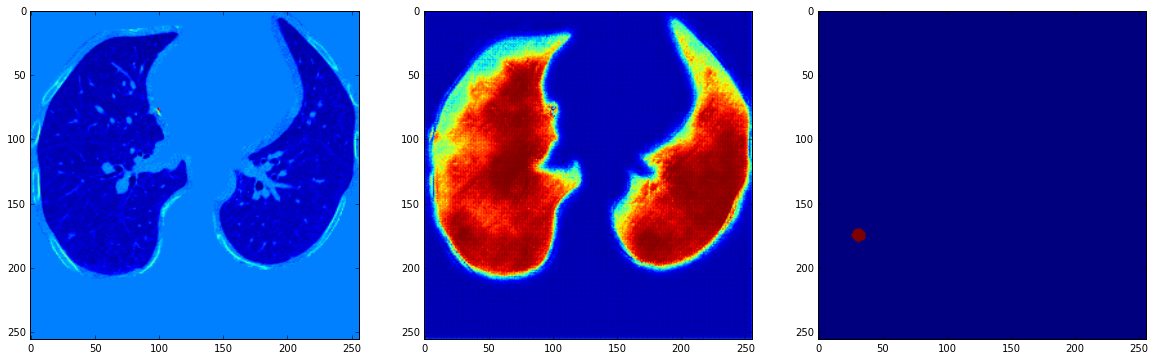

In [23]:
i=6
x = Variable(imgs_train[perm[i:i+batchsize]])
t = Variable(imgs_mask_train[perm[i:i+batchsize]])
y = unet.nodule_det(x, test=True)

plt.figure(figsize=(20,10))
plt.subplot(1, 3 ,1)
plt.imshow(x.data[0,0])
plt.subplot(1, 3 ,2)
plt.imshow(y.data[0,0])
plt.subplot(1, 3, 3)
plt.imshow(t.data[0,0])

# train cancer detector

In [ ]:
imgs_train, target_train = load_train_data() # <=適当に実装

In [ ]:
epoch = 2
batchsize = 1

for e in range(epoch):
    print 'epoch:', e
    perm = np.random.permutation(len(imgs_train))
    for i in range(0, len(perm), batchsize):
        x = Variable(imgs_train[perm[i:i+batchsize]])
        t = Variable(target_train[perm[i:i+batchsize]])
        y = unet.cancer_det(x)
        loss = F.softmax_cross_entropy(y, t)
        opt.zero_grads()
        loss.backward()
        opt.update()
        print i, loss.data